# Using the C/C++ API
This notebook shows how to use the OpenMC C/C++ API through the openmc.lib module. This module is particularly useful for multiphysics coupling because it allows you to update the density of materials and the temperatures of cells in memory, without stopping the simulation.

Warning: these bindings are still somewhat experimental and may be subject to change in future versions of OpenMC.

In [1]:
%matplotlib inline
import openmc
import openmc.lib

<b>Generate Input Files</b>

Let's start by creating a fuel rod geometry. We will make 10 zones in the z-direction which will allow us to make changes to each zone. Changes in temperature have to be made on the cell, so will make 10 cells in the axial direction. Changes in density have to be made on the material, so we will make 10  water materials. 

Materials: we will make a fuel, helium, zircaloy, and 10 water materials. 

In [2]:
material_list = []

In [3]:
uo2 = openmc.Material(material_id=1, name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)
material_list.append(uo2)

helium = openmc.Material(material_id=2, name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)
material_list.append(helium)

zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')
material_list.append(zircaloy)

for i in range(4, 14):
    water = openmc.Material(material_id=i)
    water.set_density('g/cm3', 0.7)
    water.add_element('H', 2.0)
    water.add_element('O', 1.0)
    water.add_s_alpha_beta('c_H_in_H2O')
    material_list.append(water)
    
materials_file = openmc.Materials(material_list)
materials_file.export_to_xml()

Cells: we will make a fuel cylinder, a gap cylinder, a cladding cylinder, and a water exterior. Each one will be broken into 10 cells which are the 10 axial zones. The z_list is the list of axial positions that delimit those 10 zones. To keep track of all the cells, we will create lists: fuel_list, gap_list, clad_list, and water_list. 

In [4]:
pitch = 1.25984
fuel_or = openmc.ZCylinder(r=0.39218)
clad_ir = openmc.ZCylinder(r=0.40005)
clad_or = openmc.ZCylinder(r=0.4572)
left = openmc.XPlane(x0=-pitch/2)
right = openmc.XPlane(x0=pitch/2)
back = openmc.YPlane(y0=-pitch/2)
front = openmc.YPlane(y0=pitch/2)
z = [0., 30., 60., 90., 120., 150., 180., 210., 240., 270., 300.]
z_list = [openmc.ZPlane(z0=z_i) for z_i in z]

In [5]:
left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
front.boundary_type = 'reflective'
back.boundary_type = 'reflective'
z_list[0].boundary_type = 'vacuum'
z_list[-1].boundary_type = 'vacuum'

In [6]:
fuel_list = []
gap_list = []
clad_list = []
water_list = []
for i in range(1, 11):
    fuel_list.append(openmc.Cell(cell_id=i))
    gap_list.append(openmc.Cell(cell_id=i+10))
    clad_list.append(openmc.Cell(cell_id=i+20))
    water_list.append(openmc.Cell(cell_id=i+30))
    
for j, fuels in enumerate(fuel_list):
    fuels.region = -fuel_or & +z_list[j] & -z_list[j+1]
    fuels.fill = uo2
    fuels.temperature = 800.

for j, gaps in enumerate(gap_list):
    gaps.region = +fuel_or & -clad_ir & +z_list[j] & -z_list[j+1]
    gaps.fill = helium
    gaps.temperature = 700.

for j, clads in enumerate(clad_list):
    clads.region = +clad_ir & -clad_or & +z_list[j] & -z_list[j+1]
    clads.fill = zircaloy
    clads.temperature = 600.

for j, waters in enumerate(water_list):
    waters.region = +clad_or & +left & -right & +back & -front & +z_list[j] & -z_list[j+1]
    waters.fill = material_list[j+3]
    waters.temperature = 500.

In [7]:
root = openmc.Universe(name='root universe')
root.add_cells(fuel_list)
root.add_cells(gap_list)
root.add_cells(clad_list)
root.add_cells(water_list)
geometry_file = openmc.Geometry(root)
geometry_file.export_to_xml()

If you are coupling this externally to a heat transfer solver, you will want to know the heat deposited by each fuel cell. So let's create a cell filter for the recoverable fission heat. 

In [8]:
cell_filter = openmc.CellFilter(fuel_list)
t = openmc.Tally(tally_id=1)
t.filters.append(cell_filter)
t.scores = ['fission-q-recoverable']
tallies = openmc.Tallies([t])
tallies.export_to_xml()

Let's plot our geometry to make sure it looks like we expect. Since we made new water materials in each axial cell, and we have centered the plot at 150, we should see one color for the water material in the bottom half and a different color for the water material in the top half. 

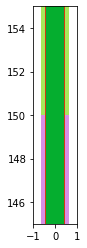

In [19]:
root.plot(basis='yz', width=[2, 10], color_by='material', origin=[0., 0., 150.], pixels=[400, 400])

Settings: everything will be standard except for the temperature settings. Since we will be working with specified temperatures, you will need temperature dependent data. I typically use the endf data found here: https://openmc.org/official-data-libraries/
Make sure your cross sections environment variable is pointing to temperature-dependent data before using the following settings.

In [13]:
lower_left = [-0.62992, -pitch/2, 0]
upper_right = [+0.62992, +pitch/2, +300]
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)

settings_file = openmc.Settings()
settings_file.batches = 100
settings_file.inactive = 10
settings_file.particles = 10000
settings_file.temperature = {'multipole': True, 'method': 'interpolation', 'range': [290, 2500]}
settings_file.source = openmc.source.Source(space=uniform_dist)
settings_file.export_to_xml()

To run a regular simulation, just use openmc.run(). 
However, we want to run a simulation that we can stop in the middle and update the material and cell properties. So we will use openmc.lib.

In [14]:
openmc.lib.init()
openmc.lib.simulation_init()

There are 10 inactive batches, so we need to run next_batch() at least 10 times before the tally is activated. 

In [15]:
for _ in range(14):
    openmc.lib.next_batch()

Let's take a look at the tally. There are 10 entries, one for each cell in the fuel.

In [16]:
t = openmc.lib.tallies[1]
print(t.mean)

[[ 4178272.4202991 ]
 [ 9595363.82759911]
 [12307462.30060902]
 [11772927.66594472]
 [11892601.29001472]
 [12203397.88895767]
 [12851791.20965905]
 [11760027.45873386]
 [ 9293110.94735569]
 [ 4511597.61592287]]


Now, let's make some changes to the temperatures. For this, we need to identify each cell by its id. We can use get_temperature() to compare the temperatures of the cells before and after the change. 

In [17]:
print("fuel temperature is: ")
print(openmc.lib.cells[5].get_temperature())
print("gap temperature is: ")
print(openmc.lib.cells[15].get_temperature())
print("clad temperature is: ")
print(openmc.lib.cells[25].get_temperature())
print("water temperature is: ")
print(openmc.lib.cells[35].get_temperature())

fuel temperature is: 
800.0
gap temperature is: 
700.0
clad temperature is: 
600.0
water temperature is: 
500.00000000000006


In [18]:
for i in range(1, 11):
    temp = 900.0
    openmc.lib.cells[i].set_temperature(temp)

In [19]:
print("fuel temperature is: ")
print(openmc.lib.cells[5].get_temperature())

fuel temperature is: 
899.9999999999999


Let's make a similar change for the water density. Again, we need to identify each material by its id.

In [20]:
for i in range(4, 14):
    density = 0.65
    openmc.lib.materials[i].set_density(density, units='g/cm3')

The new batches we run will use the new material and cell properties.

In [21]:
for _ in range(14):
    openmc.lib.next_batch()

When you're ready to end the simulation, use the following:

In [22]:
openmc.lib.simulation_finalize()
openmc.lib.finalize()